# LSTM Time Series Forecasting with PyTorch

This Jupyter Notebook provides a full implementation of training an LSTM model using PyTorch on your pivot table dataset. The steps include data preparation, model definition, training, and evaluation.

---

## Table of Contents

1. [Data Preparation](#1)
   - Import Libraries
   - Load and Preprocess Data
2. [Define Dataset Class](#2)
3. [Split Data into Training and Validation Sets](#3)
4. [Create DataLoaders](#4)
5. [Define the LSTM Model](#5)
6. [Initialize Model, Loss Function, and Optimizer](#6)
7. [Training Loop](#7)
8. [Evaluate the Model](#8)
9. [Save the Model](#9)
10. [Conclusion](#10)

---


<a id="1"></a>
## 1. Data Preparation

### Import Libraries


In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Load and Preprocess Data

Assuming your pivot table dataset in "../data/processed/2023_complete_pivot.parquet", with dates as the index and country-brand pairs as columns.


In [2]:
# Load the dataset
df_pivot = pd.read_parquet("../data/processed/2023_complete_pivot.parquet")

# Reset index to turn the date into a column
df_pivot = df_pivot.reset_index()

# Rename the 'index' column to 'date'
df_pivot = df_pivot.rename(columns={'index': 'date'})

# Melt the DataFrame to long format
df = df_pivot.melt(id_vars=['date'], var_name='id', value_name='value')

# Sort by 'id' and 'date'
df = df.sort_values(['id', 'date']).reset_index(drop=True)

# Convert 'date' to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Display the first few rows
df.head()


,date,id,value
0,2013-01-01,Aldovia-AIMST,0.000000
1,2013-01-02,Aldovia-AIMST,0.006284
2,2013-01-03,Aldovia-AIMST,0.123459
3,2013-01-04,Aldovia-AIMST,0.055607
4,2013-01-05,Aldovia-AIMST,0.000000


<a id="2"></a>
## 2. Define Dataset Class


In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        sequence = torch.FloatTensor(self.sequences[idx]).unsqueeze(-1)  # Shape: [sequence_length, 1]
        target = torch.tensor(self.targets[idx], dtype=torch.float32)    # Shape: [ ]
        return sequence, target


<a id="3"></a>
## 3. Split Data into Training and Validation Sets


In [4]:
# Parameters
cutoff_percentage = 0.8
sequence_length = 30  # Adjust based on your data
ratio_zeros = 0.5

# Determine the cutoff date for the split (e.g., last 20% for validation)
cutoff_date = df['date'].quantile(cutoff_percentage)
cutoff_date = np.datetime64(cutoff_date)

# Initialize lists for training and validation data
train_sequences = []
train_targets = []
val_sequences = []
val_targets = []

def generate_sequences(values, cutoff_idx, seq_length, zero_ratio):
    """
    Generate sequences and targets from the values array.
    
    Parameters:
    - values (np.ndarray): Array of values.
    - cutoff_idx (int): Index to split training and validation data.
    - seq_length (int): Length of each sequence.
    - zero_ratio (float): Maximum allowed ratio of zeros in a sequence.
    
    Returns:
    - train_seq, train_tgt, val_seq, val_tgt: Lists of training and validation sequences and targets.
    """
    num_values = len(values)
    
    # Training indices
    train_end = cutoff_idx - seq_length
    train_indices = np.arange(0, train_end)
    
    # Validation indices
    val_start = cutoff_idx
    val_end = num_values - seq_length
    val_indices = np.arange(val_start, val_end)
    
    # Function to create sequences and targets
    def create_seq_tgt(indices):
        seq = np.lib.stride_tricks.sliding_window_view(values, window_shape=seq_length)
        tgt = values[seq_length:]
        selected_seq = seq[indices]
        selected_tgt = tgt[indices]
        return selected_seq, selected_tgt
    
    # Create training sequences and targets
    train_seq, train_tgt = create_seq_tgt(train_indices)
    
    # Create validation sequences and targets
    val_seq, val_tgt = create_seq_tgt(val_indices)
    
    # Calculate ratio of zeros in each sequence
    train_zero_ratio = np.mean(train_seq == 0.0, axis=1)
    val_zero_ratio = np.mean(val_seq == 0.0, axis=1)
    
    # Filter sequences based on zero_ratio
    train_mask = train_zero_ratio <= zero_ratio
    val_mask = val_zero_ratio <= zero_ratio
    
    # Apply mask
    train_seq_filtered = train_seq[train_mask]
    train_tgt_filtered = train_tgt[train_mask]
    
    val_seq_filtered = val_seq[val_mask]
    val_tgt_filtered = val_tgt[val_mask]
    
    return train_seq_filtered, train_tgt_filtered, val_seq_filtered, val_tgt_filtered

# Iterate over each group and generate sequences
for name, group in df.groupby('id'):
    group = group.sort_values('date')
    values = group['value'].values
    dates = group['date'].values
    cutoff_index = np.searchsorted(dates, cutoff_date)
    
    # Ensure cutoff_index is within bounds
    cutoff_index = min(cutoff_index, len(values))
    
    # Generate sequences and targets
    train_seq, train_tgt, val_seq, val_tgt = generate_sequences(
        values, cutoff_index, sequence_length, ratio_zeros
    )
    
    # Append to the main lists
    train_sequences.append(train_seq)
    train_targets.append(train_tgt)
    val_sequences.append(val_seq)
    val_targets.append(val_tgt)

# Concatenate all sequences and targets
train_sequences = np.concatenate(train_sequences) if train_sequences else np.array([])
train_targets = np.concatenate(train_targets) if train_targets else np.array([])
val_sequences = np.concatenate(val_sequences) if val_sequences else np.array([])
val_targets = np.concatenate(val_targets) if val_targets else np.array([])

print(f'Total training samples: {len(train_sequences)}')
print(f'Total validation samples: {len(val_sequences)}')

# Convert to lists of sequences and targets for Dataset
train_sequences = list(train_sequences)
train_targets = list(train_targets)
val_sequences = list(val_sequences)
val_targets = list(val_targets)

Total training samples: 2218278
Total validation samples: 514141


<a id="4"></a>
## 4. Create DataLoaders


In [5]:
batch_size = 128  # Adjust based on your hardware capabilities

# Create dataset instances
train_dataset = TimeSeriesDataset(train_sequences, train_targets)
val_dataset = TimeSeriesDataset(val_sequences, val_targets)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f'Total training batches: {len(train_loader)}')

Total training batches: 17331


<a id="5"></a>
## 5. Define the LSTM Model


In [ ]:
class LSTMForecastingModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMForecastingModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define output layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out


<a id="6"></a>
## 6. Initialize Model, Loss Function, and Optimizer


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMForecastingModel(hidden_size=8).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(device)


cuda


<a id="7"></a>
## 7. Training Loop


In [20]:
import time
num_epochs = 20  # Adjust based on your needs
last_epoch_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for sequences, targets in train_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences = sequences.to(device)
            targets = targets.to(device).view(-1)
            outputs = model(sequences).view(-1)
            loss = criterion(outputs.squeeze(), targets)
            val_losses.append(loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {np.mean(train_losses):.6f}, '
          f'Val Loss: {np.mean(val_losses):.6f}'
          f'Elapsed time: {time.time() - last_epoch_time:.2f} seconds'),
    last_epoch_time = time.time() 


c:\dev\Bonkis-Jake\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

<a id="8"></a>
## 8. Evaluate the Model

### Calculate Metrics


In [ ]:
model.eval()
predictions = []
actuals = []
i = 0
with torch.no_grad():
    for sequences, targets in val_loader:
        sequences = sequences.to(device)
        outputs = model(sequences)
        predictions.extend(outputs.squeeze().cpu().numpy())
        actuals.extend(targets.cpu().numpy())
        i += 1
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)

print(f'Validation MAE: {mae:.4f}')
print(f'Validation RMSE: {rmse:.4f}')


secuence in epoch 0
secuence in epoch 1
secuence in epoch 2
secuence in epoch 3
secuence in epoch 4
secuence in epoch 5
secuence in epoch 6
secuence in epoch 7
secuence in epoch 8
secuence in epoch 9
secuence in epoch 10
secuence in epoch 11
secuence in epoch 12
secuence in epoch 13
secuence in epoch 14
secuence in epoch 15
secuence in epoch 16
secuence in epoch 17
secuence in epoch 18
secuence in epoch 19
secuence in epoch 20
secuence in epoch 21
secuence in epoch 22
secuence in epoch 23
secuence in epoch 24
secuence in epoch 25
secuence in epoch 26
secuence in epoch 27
secuence in epoch 28
secuence in epoch 29
secuence in epoch 30
secuence in epoch 31
secuence in epoch 32
secuence in epoch 33
secuence in epoch 34
secuence in epoch 35
secuence in epoch 36
secuence in epoch 37
secuence in epoch 38
secuence in epoch 39
secuence in epoch 40
secuence in epoch 41
secuence in epoch 42
secuence in epoch 43
secuence in epoch 44
secuence in epoch 45
secuence in epoch 46
secuence in epoch 47
se

secuence in epoch 840
secuence in epoch 841
secuence in epoch 842
secuence in epoch 843
secuence in epoch 844
secuence in epoch 845
secuence in epoch 846
secuence in epoch 847
secuence in epoch 848
secuence in epoch 849
secuence in epoch 850
secuence in epoch 851
secuence in epoch 852
secuence in epoch 853
secuence in epoch 854
secuence in epoch 855
secuence in epoch 856
secuence in epoch 857
secuence in epoch 858
secuence in epoch 859
secuence in epoch 860
secuence in epoch 861
secuence in epoch 862
secuence in epoch 863
secuence in epoch 864
secuence in epoch 865
secuence in epoch 866
secuence in epoch 867
secuence in epoch 868
secuence in epoch 869
secuence in epoch 870
secuence in epoch 871
secuence in epoch 872
secuence in epoch 873
secuence in epoch 874
secuence in epoch 875
secuence in epoch 876
secuence in epoch 877
secuence in epoch 878
secuence in epoch 879
secuence in epoch 880
secuence in epoch 881
secuence in epoch 882
secuence in epoch 883
secuence in epoch 884
secuence i

c:\dev\Bonkis-Jake\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Validation MAE: 0.0303
Validation RMSE: 0.0462


### Visualize Predictions


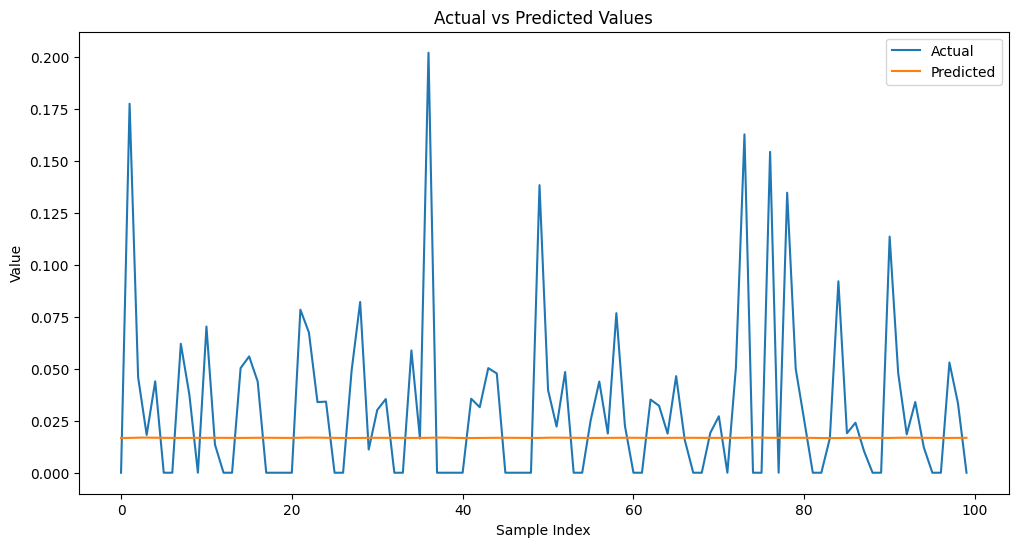

In [ ]:
# Plot the first 100 predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()


<a id="9"></a>
## 9. Save the Model


In [ ]:
torch.save(model.state_dict(), 'lstm_forecasting_model.pth')


<a id="10"></a>
## 10. Conclusion

You've successfully trained an LSTM model on your pivot table dataset using PyTorch. You can now use this model to make predictions on future data or further refine it by tuning hyperparameters or incorporating additional features.

---

## Additional Notes

- **Adjust Hyperparameters**: Experiment with `sequence_length`, `hidden_size`, `num_layers`, `batch_size`, and `num_epochs` to optimize performance.
- **Scaling Data**: If your data has varying scales, consider scaling or normalizing it.
- **Early Stopping**: Implement early stopping to prevent overfitting if necessary.
- **Feature Engineering**: Even without exogenous variables, adding features like day of the week or month can help capture temporal patterns.

## Example: Making Future Predictions


In [ ]:
def predict_future(model, initial_sequence, prediction_length):
    model.eval()
    predictions = []
    sequence = initial_sequence.copy()
    
    for _ in range(prediction_length):
        seq_input = torch.FloatTensor(sequence[-sequence_length:]).unsqueeze(0).unsqueeze(-1).to(device)
        with torch.no_grad():
            pred = model(seq_input)
        pred_value = pred.item()
        predictions.append(pred_value)
        sequence = np.append(sequence, pred_value)
    return predictions

# Example usage:
# Get the last sequence from the validation data
latest_sequence = val_sequences[-1]
future_predictions = predict_future(model, latest_sequence, prediction_length=7)

print("Future Predictions:", future_predictions)
